In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tbats import TBATS
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


Importing plotly failed. Interactive plots will not work.


In [2]:
def Mape(predicted_values,true_values):
    # Calculate MAPE for train data
    return np.mean(np.abs((predicted_values - true_values) / true_values)*100)

In [3]:
def Bias(predicted_values,true_values):
   return np.mean(predicted_values-true_values)

In [4]:
def Dw_Pvalue(resid_values):
    # Calculate Durbin-Watson p-value
    dw_test = sm.stats.stattools.durbin_watson(resid_values)
    dw_p_value=2*(1-norm.cdf(abs(dw_test)))
    return dw_p_value

In [5]:
def Lb_Pvalue(resid_values):
    # Perform the Ljung-Box test
    lb_test = sm.stats.acorr_ljungbox(resid_values)
    ar1=np.array(lb_test['lb_pvalue'])
    return ar1[0]

In [6]:
def CoV(data_truevalues):
    cv = np.std(data_truevalues) / np.mean(data_truevalues)
    return cv


In [7]:
def Rmse(forecast,truevalues):
    return np.sqrt(mean_squared_error(truevalues, forecast))

In [8]:
def Accuracy(rmse,truevalues):
    return (100 - (rmse / np.mean(truevalues) * 100))

In [9]:
def Trend_comp(past1year_observation,next1year_forecast):
    return (np.mean(past1year_observation))/(np.mean(next1year_forecast))

In [10]:
def mase(train_data,test_data,forecast):
    
    naive_forecast = train_data.iloc[-1]

    # Repeat the naive forecast for the length of the test data
    naive_forecast = np.repeat(naive_forecast, len(test_data))

    # Calculate the mean absolute error (MAE)
    naive_mae = mean_absolute_error(test_data, naive_forecast)
    mae_model = mean_absolute_error(test_data,forecast)
    
    return (mae_model/naive_mae)

In [11]:
def ACF_estimate_p_q(data):
    # Calculate ACF and PACF
    
    len1=len(data)/2-1
    max_lags=min(len1,15)

    acf_values = sm.tsa.stattools.acf(data, nlags=max_lags)
    pacf_values = sm.tsa.stattools.pacf(data, nlags=max_lags)
    

    # Find the significant lags based on ACF and PACF plots
    q = np.where(acf_values > 0.2)[0][-1]
    p = np.where(pacf_values > 0.2)[0][-1]
    
    return p, q

In [12]:
def best_arima(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]
    
    result = adfuller(data['Quantity'])

    # Extract ADF test statistics
    adf_stat = result[0]
    p_value = result[1]

    # Define significance level
    alpha = 0.05

    # Check if the series is stationary or not
    if p_value < alpha:
        d1=0
        d2=1
    else:
        d1 = 1
        d2=2
        
    # Define the parameter ranges for p, d, q, P, D, Q
    p_values = range(1, 7)
    d_values = range(d1,d2)
    q_values = range(1, 7)

    best_rmse = float('inf')  # Initialize best RMSE with a high value
    best_model = None
    best_p, best_d, best_q = None, None, None

    # Perform grid search
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(train_data['Quantity'], order=(p, d, q))
            model_fit = model.fit()

            # Forecast the data
            forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

            # Calculate RMSE
            low_rmse = Rmse(forecast,test_data['Quantity'])

            if low_rmse < best_rmse:
                best_model = model_fit
                best_rmse = low_rmse
                best_p, best_d, best_q = p, d, q
        except:
            continue

    acf_p,acf_q=ACF_estimate_p_q(data['Quantity'])
    print("Estimate of p and q from acf plots",acf_p,acf_q)

    for d in range(d1,d2):

        acf_model = ARIMA(train_data['Quantity'], order=(acf_p, d, acf_q))
        acf_model_fit = acf_model.fit()

        # Forecast the data
        acf_forecast = acf_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

        # Calculate RMSE
        acf_rmse = Rmse(acf_forecast,test_data['Quantity'])
        
        if acf_rmse < best_rmse:
            best_model = acf_model_fit
            best_rmse = acf_rmse
            best_p, best_d, best_q = acf_p, d, acf_q


            
    final_order=[best_p, best_d, best_q]
    print("FinalOrder_ARIMA",final_order)

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    mape_test=Mape(forecast,test_data['Quantity'])
    
    return mape_test,best_model,final_order


In [13]:
def metrics_arima(best_model,data,sku,final_order):

    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    future_forecast = best_model.forecast(steps=25)
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(best_model.fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    #creating a appeneded data frame for different forecasts
    
    # Get the last date from the test data
    last_date_str = data.index[-1]

    # Convert the last date string to a pandas datetime object
    last_date = pd.to_datetime(last_date_str)

    # Generate dates for the forecast
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(25)]
    forecast_dates = [month.strftime("%d-%m-%Y") for month in forecast_dates]

    # Create a DataFrame with forecasted dates and values
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_forecast,'SKU':sku})

    mape_train=Mape(best_model.fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(best_model.fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model.resid)
    lbpvalue1=Lb_Pvalue(best_model.resid)
    cov=CoV(data['Quantity'])
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)
    
    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(best_model.fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model.resid))
    print("Bias-Train",Bias(best_model.fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model.resid))
    print("Coefficient of variation",CoV(data['Quantity']))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))

    # Create a DataFrame to store the evaluation metrics
    metrics = pd.DataFrame({
    'Metric': ['SKU','BEST MODEL','order','MAPE (train)', 'MAPE (test)', 'RMSE', 'test_Accuracy', 'train_accuarcy','Bias-test','Bias-train', 'Durbin-Watson p-value', 'Ljung-Box p-value',
               'Coefficient of Variation', 'MASE','Trend Compare'],
    'Value': [sku,"ARIMA MODEL",final_order,mape_train, mape_test, best_rmse, test_accuracy,train_accuracy, bias_test,bias_train, dwpvalue1, lbpvalue1, cov, MASE1,trend_compare]})
    
    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('ARIMA Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()

    return forecast_df,metrics

In [14]:
def best_arma(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]
        
    # Define the parameter ranges for p, d, q, P, D, Q
    p_values = range(1, 7)
    q_values = range(1, 7)

    best_rmse = float('inf')  # Initialize best RMSE with a high value
    best_model = None
    best_p, best_d, best_q = None, None, None

    # Perform grid search
    for p, q in product(p_values, q_values):
        try:
            model = ARIMA(train_data['Quantity'], order=(p, 0, q))
            model_fit = model.fit()

            # Forecast the data
            forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

            # Calculate RMSE
            low_rmse = Rmse(forecast,test_data['Quantity'])

            if low_rmse < best_rmse:
                best_model = model_fit
                best_rmse = low_rmse
                best_p, best_d, best_q = p, 0, q
        except:
            continue

    acf_p,acf_q=ACF_estimate_p_q(data['Quantity'])
    print("Estimate of p and q from acf plots",acf_p,acf_q)

    acf_model = ARIMA(train_data['Quantity'], order=(acf_p, 0, acf_q))
    acf_model_fit = acf_model.fit()

    # Forecast the data
    acf_forecast = acf_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate RMSE
    acf_rmse = Rmse(acf_forecast,test_data['Quantity'])
        
    if acf_rmse < best_rmse:
        best_model = acf_model_fit
        best_rmse = acf_rmse
        best_p, best_d, best_q = acf_p, 0, acf_q
       
    final_order=[best_p, best_d, best_q]
    print("FinalOrder_ARMA",final_order)

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    mape_test=Mape(forecast,test_data['Quantity'])

    return mape_test,best_model,final_order


In [15]:
def metrics_arma(best_model,data,sku,final_order):

    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    future_forecast = best_model.forecast(steps=25)
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(best_model.fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    #creating a appeneded data frame for different forecasts
    
    # Get the last date from the test data
    last_date_str = data.index[-1]

    # Convert the last date string to a pandas datetime object
    last_date = pd.to_datetime(last_date_str)

    # Generate dates for the forecast
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(25)]
    forecast_dates = [month.strftime("%d-%m-%Y") for month in forecast_dates]

    # Create a DataFrame with forecasted dates and values
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_forecast,'SKU':sku})

    mape_train=Mape(best_model.fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(best_model.fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model.resid)
    lbpvalue1=Lb_Pvalue(best_model.resid)
    cov=CoV(data['Quantity'])
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)
    
    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(best_model.fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model.resid))
    print("Bias-Train",Bias(best_model.fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model.resid))
    print("Coefficient of variation",CoV(data['Quantity']))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))

    # Create a DataFrame to store the evaluation metrics
    metrics = pd.DataFrame({
    'Metric': ['SKU','BEST MODEL','order','MAPE (train)', 'MAPE (test)', 'RMSE', 'test_Accuracy', 'train_accuarcy','Bias-test','Bias-train', 'Durbin-Watson p-value', 'Ljung-Box p-value',
               'Coefficient of Variation', 'MASE','Trend Compare'],
    'Value': [sku,"ARMA MODEL",final_order,mape_train, mape_test, best_rmse, test_accuracy,train_accuracy, bias_test,bias_train, dwpvalue1, lbpvalue1, cov, MASE1,trend_compare]})
 
    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('ARMA Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()

    return forecast_df,metrics

In [16]:
def best_sarima(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]
    
    result = adfuller(data['Quantity'])

    # Extract ADF test statistics
    adf_stat = result[0]
    p_value = result[1]

    # Define significance level
    alpha = 0.05

    # Check if the series is stationary or not
    if p_value < alpha:
        d1=0
        d2=1
    else:
        d1 = 1
        d2=2
        
    if (len(data))>24:
        m=12
    else:
        m=6

    # Define the parameter ranges for p, d, q, P, D, Q
    p_values = range(1, 4)
    d_values = range(d1, d2)
    q_values = range(1, 4)
    P_values = range(1, 4)
    D_values = range(1, 2)
    Q_values = range(1, 4)

    # Initialize variables for the best model
    best_model = None
    best_rmse = float('inf')

    # Brute force approach to find the best SARIMA model
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Fit the SARIMA model
            model = SARIMAX(train_data['Quantity'], order=(p, d, q), seasonal_order=(P, D, Q, m))
            model_fit = model.fit()

            # Forecast the data
            forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

            # Calculate RMSE 
            rmse = np.sqrt(mean_squared_error(test_data['Quantity'], forecast))

            # Update the best model if the current model has lower RMSE
            if rmse < best_rmse:
                best_model = model_fit
                best_rmse = rmse
                a=p
                b=d
                c=q
                A=P
                B=D
                C=Q
        except:
            continue

    # Forecast the data
            
    final_order=[a,b,c,A,B,C,m]
    print("FinalOrder_SARIMA",final_order)

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    mape_test=Mape(forecast,test_data['Quantity'])
    
    return mape_test,best_model,final_order

In [17]:
def metrics_sarima(best_model,data,sku,final_order):

    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    future_forecast = best_model.forecast(steps=25)
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(best_model.fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    #creating a appeneded data frame for different forecasts
    
    # Get the last date from the test data
    last_date_str = data.index[-1]

    # Convert the last date string to a pandas datetime object
    last_date = pd.to_datetime(last_date_str)

    # Generate dates for the forecast
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(25)]
    forecast_dates = [month.strftime("%d-%m-%Y") for month in forecast_dates]

    # Create a DataFrame with forecasted dates and values
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_forecast,'SKU':sku})

    mape_train=Mape(best_model.fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(best_model.fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model.resid)
    lbpvalue1=Lb_Pvalue(best_model.resid)
    cov=CoV(data['Quantity'])
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)
    
    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(best_model.fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model.resid))
    print("Bias-Train",Bias(best_model.fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model.resid))
    print("Coefficient of variation",CoV(data['Quantity']))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))

        # Create a DataFrame to store the evaluation metrics
    metrics = pd.DataFrame({
    'Metric': ['SKU','BEST MODEL','order','MAPE (train)', 'MAPE (test)', 'RMSE', 'test_Accuracy', 'train_accuarcy','Bias-test','Bias-train', 'Durbin-Watson p-value', 'Ljung-Box p-value',
               'Coefficient of Variation', 'MASE','Trend Compare'],
    'Value': [sku,"SARIMA MODEL",final_order,mape_train, mape_test, best_rmse, test_accuracy,train_accuracy, bias_test,bias_train, dwpvalue1, lbpvalue1, cov, MASE1,trend_compare]})
    
    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('SARIMA Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()

    return forecast_df,metrics

In [18]:
def best_holtwinter(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]
    
    # Define the number of seasonal periods
    
    if (len(data))>24:
        seasonal_periods=12
    else:
        seasonal_periods=6

    # Define the range of parameter values

    alpha_range = np.arange(0.0, 0.2, 0.02)
    beta_range = np.arange(0.0, 0.2, 0.02) 
    gamma_range = np.arange(0.0, 0.2, 0.02)
    seasonalvariation_range = ['add', 'mul']
    trendvariation_range=['add','mul']




    # Initialize variables for storing best parameters and RMSE
    best_alpha = best_beta = best_gamma = None
    best_svariation =best_tvariation= None
    best_rmse = float('inf')

    # Perform grid search
    for alpha, beta, gamma, s_variation,t_variation in product(alpha_range, beta_range, gamma_range, seasonalvariation_range,trendvariation_range):
        try:
            model =ExponentialSmoothing(train_data['Quantity'], trend=t_variation, seasonal=s_variation, seasonal_periods=seasonal_periods)
            model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

            # Forecast the data
            forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

            # Calculate RMSE
            low_rmse = Rmse(forecast,test_data['Quantity'])

            if low_rmse < best_rmse:
                best_model = model_fit
                best_rmse = low_rmse
                best_alpha = alpha
                best_beta = beta
                best_gamma = gamma
                best_svariation = s_variation
                best_tvariation= t_variation
        except:
            continue

            
    final_order=[best_alpha, best_beta, best_gamma,best_svariation,best_tvariation]
    print("FinalOrder: aplha, beta , gamma , seasonal variaton,trend variation - HOLT WINTER",final_order)

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    mape_test=Mape(forecast,test_data['Quantity'])

    return mape_test,best_model,final_order

In [19]:
def metrics_hw(best_model,data,sku,final_order):

    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    future_forecast = best_model.forecast(steps=25)
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(best_model.fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    #creating a appeneded data frame for different forecasts
    
    # Get the last date from the test data
    last_date_str = data.index[-1]

    # Convert the last date string to a pandas datetime object
    last_date = pd.to_datetime(last_date_str)

    # Generate dates for the forecast
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(25)]
    forecast_dates = [month.strftime("%d-%m-%Y") for month in forecast_dates]

    # Create a DataFrame with forecasted dates and values
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_forecast,'SKU':sku})

    mape_train=Mape(best_model.fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(best_model.fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model.resid)
    lbpvalue1=Lb_Pvalue(best_model.resid)
    cov=CoV(data['Quantity'])
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)

    # Create a DataFrame to store the evaluation metrics
    metrics = pd.DataFrame({
    'Metric': ['SKU','BEST MODEL','order','MAPE (train)', 'MAPE (test)', 'RMSE', 'test_Accuracy', 'train_accuarcy','Bias-test','Bias-train', 'Durbin-Watson p-value', 'Ljung-Box p-value',
               'Coefficient of Variation', 'MASE','Trend Compare'],
    'Value': [sku,"Holt Winters MODEL",final_order,mape_train, mape_test, best_rmse, test_accuracy,train_accuracy, bias_test,bias_train, dwpvalue1, lbpvalue1, cov, MASE1,trend_compare]})

    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(best_model.fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model.resid))
    print("Bias-Train",Bias(best_model.fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model.resid))
    print("Coefficient of variation",CoV(data['Quantity']))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))
    
    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('HW Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()

    return forecast_df,metrics

In [20]:
def best_TBATS(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6
    
    train_data=data
    test_data=data[-test_size:]
        
    # Define the parameter ranges for p, d, q, P, D, Q
    p_values = range(1, 7)
    q_values = range(1, 7)
    seasonal_harmonics_Range=range(1,4)
    boolean_values=['True','False']

    acf_p,acf_q=ACF_estimate_p_q(data['Quantity'])
    print("p,q using plots",acf_p,acf_q)

    best_rmse = float('inf')  # Initialize best RMSE with a high value
    best_model = None
    best_p, best_q = None, None
    best_seasonal_harmonic=None
    used_boxcox=None
    used_trend=None
    used_dampedtrend=None
    used_arma=None
    seasonal_period=None
    S_P_range = np.array([4, 6, 12])

    # Perform grid search
    for S_P in product(S_P_range):
        try:
            model = TBATS(
                use_box_cox='True',
                use_trend='True',
                use_damped_trend='True',
                seasonal_periods=(S_P,),
                use_arma_errors='True',
            )
            
            model_fit = model.fit(train_data['Quantity'])

            # Forecast the data
            fittedvalues = train_data['Quantity']+model_fit.resid
            forecast = fittedvalues[-12:]

            # Calculate RMSE
            low_rmse = Rmse(forecast,test_data['Quantity'])

            if low_rmse < best_rmse:
                best_model = model_fit
                best_rmse = low_rmse
                used_boxcox='True'
                used_trend='True'
                used_dampedtrend='True'
                used_arma='True'
                seasonal_period=S_P

        except:
            continue

    
       
    final_order=[best_p, best_q,best_seasonal_harmonic,used_boxcox,used_trend,used_dampedtrend,used_arma,seasonal_period]
    print("best_p, best_q,best_seasonal_harmonic,used_boxcox,used_trend,used_dampedtrend,used_arma,seasonal_period - TBATS",final_order)

    # Forecast the data
    fittedvalues = train_data['Quantity']+best_model.resid
    forecast = fittedvalues[-12:]
    mape_test=Mape(forecast,test_data['Quantity'])

    return mape_test,best_model,final_order



In [21]:
def metrics_tbats(best_model,data,sku,final_order):

    if (len(data))>24:
        test_size=12
    else:
        test_size=6
    
    train_data=data
    test_data=data[-test_size:]

    # Forecast the data
    fittedvalues = train_data['Quantity']+best_model.resid
    forecast = fittedvalues[-12:]
    future_forecast = best_model.forecast(steps=25)
    
    #creating a appeneded data frame for different forecasts
    
    # Get the last date from the test data
    last_date_str = data.index[-1]

    # Convert the last date string to a pandas datetime object
    last_date = pd.to_datetime(last_date_str)

    # Generate dates for the forecast
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(25)]
    forecast_dates = [month.strftime("%d-%m-%Y") for month in forecast_dates]

    # Create a DataFrame with forecasted dates and values
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': future_forecast,'SKU':sku})    
    
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    mape_train=Mape(fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model)
    lbpvalue1=Lb_Pvalue(best_model)
    cov=CoV(data)
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)
    
    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model))
    print("Bias-Train",Bias(fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model))
    print("Coefficient of variation",CoV(data))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))
    
    # Create a DataFrame to store the evaluation metrics
    metrics = pd.DataFrame({
    'Metric': ['SKU','BEST MODEL','order','MAPE (train)', 'MAPE (test)', 'RMSE', 'test_Accuracy', 'train_accuarcy','Bias-test','Bias-train', 'Durbin-Watson p-value', 'Ljung-Box p-value',
               'Coefficient of Variation', 'MASE','Trend Compare'],
    'Value': [sku,"TBATS MODEL",final_order,mape_train, mape_test, best_rmse, test_accuracy,train_accuracy, bias_test,bias_train, dwpvalue1, lbpvalue1, cov, MASE1,trend_compare]})

    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(test_data.index, forecast, label='Forecast')
    last_index = test_data.index[-1]
    future_indices = pd.date_range(start=last_index, periods=25, freq='M')
    plt.plot(future_indices, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('TBATS Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()

    return forecast_df,metrics

C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\442881389.py:38: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\442881389.py:38: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\stat

FinalOrder: aplha, beta , gamma , seasonal variaton,trend variation - HOLT WINTER [0.0, 0.08, 0.0, 'add', 'add']
p,q using plots 12 0
best_p, best_q,best_seasonal_harmonic,used_boxcox,used_trend,used_dampedtrend,used_arma,seasonal_period - TBATS [None, None, None, 'True', 'True', 'True', 'True', 12]
Best MODEL = Holt WInter's Exponential SMoothing
Final_oder= [0.0, 0.08, 0.0, 'add', 'add']
SKU: 300000845
test_Accuracy: 70.20864050165125
train_Accuracy: 65.80131811637182
Best_RMSE 2435.9277485818584
Train_RMSE 2526.9634035025424
Mape_Train 44.33056296618505
Mape_test 43.68552256883138
DW_Pvalue 0.016563287919130643
Bias-Train 0.021753919424827472
Bias-Test -44.50882819771656
LB_Pvalue 0.10508618015764885
Coefficient of variation 0.47611423562597427
Mase 0.2945605492497537
Trend Comparison 0.8769598066435417


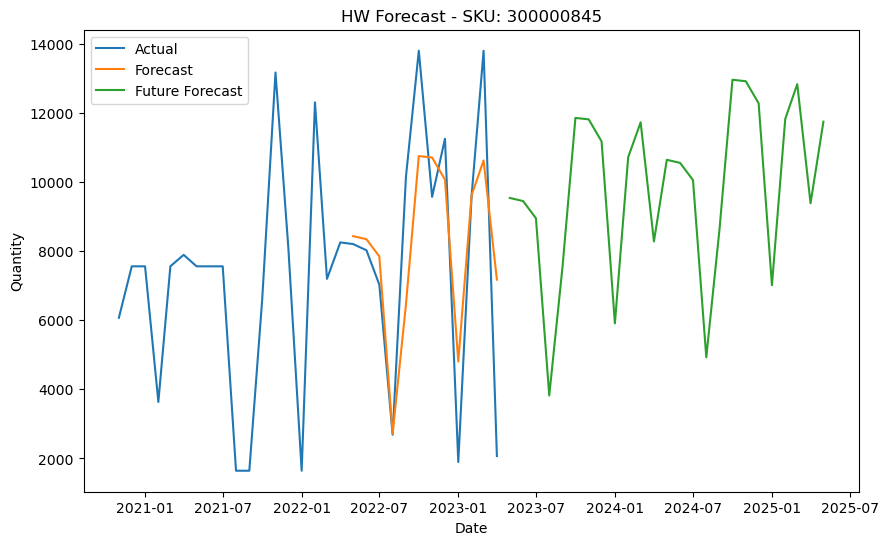


SKU: 300034265


C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\2710917457.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sku_data["Date"] = pd.to_datetime(sku_data["Date"])
C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\2710917457.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_sku_data["ds"] = pd.to_datetime(prophet_sku_data["ds"])
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inf

Estimate of p and q from acf plots 15 15


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\bas

FinalOrder_ARIMA [3, 0, 3]


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471:

Estimate of p and q from acf plots 15 15


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


FinalOrder_ARMA [3, 0, 3]


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\bas

FinalOrder_SARIMA [1, 0, 2, 1, 1, 1, 12]


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\442881389.py:38: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\p90014646\AppData\Local\Temp\ipykernel_19904\442881389.py:38: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
c:\Users\p90014646\.conda\envs\SKU

FinalOrder: aplha, beta , gamma , seasonal variaton,trend variation - HOLT WINTER [0.04, 0.02, 0.0, 'mul', 'mul']
p,q using plots 15 15
best_p, best_q,best_seasonal_harmonic,used_boxcox,used_trend,used_dampedtrend,used_arma,seasonal_period - TBATS [None, None, None, 'True', 'True', 'True', 'True', 12]
Best MODEL = Holt WInter's Exponential SMoothing
Final_oder= [0.04, 0.02, 0.0, 'mul', 'mul']
SKU: 300034265
test_Accuracy: 36.50452733080486
train_Accuracy: 57.04656461956986
Best_RMSE 5290.49569569123
Train_RMSE 6386.24054489857
Mape_Train 7588.785961714981
Mape_test 69.8409773796807
DW_Pvalue 0.1604267780074129
Bias-Train 840.5718547432899
Bias-Test -774.2562808441776
LB_Pvalue 0.0015287114471500653
Coefficient of variation 0.5549277039982082
Mase 0.950174450161807
Trend Comparison 1.1817473687623032


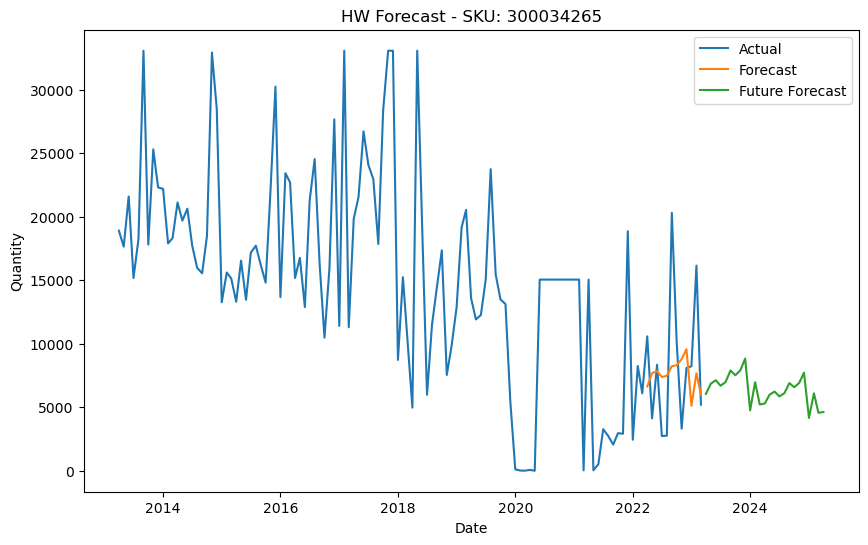

In [22]:
    
data=pd.read_csv('./../Cleaning/cleaned_data_2.csv')

prophet_data=data.copy()

#Prophet Version

prophet_data = prophet_data.rename(columns={'Date': 'ds', 'Quantity': 'y'})

# Convert the "Date" column to datetime format
prophet_data["ds"] = pd.to_datetime(prophet_data["ds"], format="%d-%m-%Y")

# Convert the "Date" column back to string format with "mm-dd-yyyy" format
prophet_data["ds"] = prophet_data["ds"].dt.strftime("%m-%d-%Y")

# Convert the "Date" column to datetime format
data["Date"] = pd.to_datetime(data["Date"], format="%d-%m-%Y")

# Convert the "Date" column back to string format with "mm-dd-yyyy" format
data["Date"] = data["Date"].dt.strftime("%m-%d-%Y")

# Get unique SKU numbers from the dataset
sku_numbers = data['SKU'].unique()

future_forecast_data = pd.DataFrame()
metrics_data=pd.DataFrame()

# Iterate over each SKU number
for sku in sku_numbers:
    
    sku_data = data[data['SKU'] == sku]
    sku_data["Date"] = pd.to_datetime(sku_data["Date"])
    sku_data.set_index('Date',inplace=True)

    print("SKU:", sku)

    prophet_sku_data = prophet_data[prophet_data['SKU'] == sku]
    prophet_sku_data["ds"] = pd.to_datetime(prophet_sku_data["ds"])

    bestmape_arima,bestmodel_arima,finalorder_arima = best_arima(sku_data, sku)
    bestmape_arma,bestmodel_arma,finalorder_arma = best_arma(sku_data, sku)
    bestmape_sarima,bestmodel_sarima,finalorder_sarima = best_sarima(sku_data, sku)
    bestmape_hw,bestmodel_hw,finalorder_hw = best_holtwinter(sku_data, sku)
    bestmape_tbats,bestmodel_tbats,finalorder_tbats = best_TBATS(sku_data, sku)

    least_mape=min(bestmape_arima,bestmape_arma,bestmape_sarima,bestmape_hw,bestmape_tbats)

    if least_mape == bestmape_arima:
        print("Best MODEL = ARIMA")
        print("Final_oder=",finalorder_arima)
        forecast_df,metrics=metrics_arima(bestmodel_arima,sku_data, sku,finalorder_arima)

        metrics_data=pd.concat([metrics_data,metrics])
        future_forecast_data=pd.concat([future_forecast_data,forecast_df])

    elif least_mape == bestmape_arma:
        print("Best MODEL = ARMA")
        print("Final_oder=",finalorder_arma)
        forecast_df,metrics=metrics_arma(bestmodel_arma,sku_data, sku,finalorder_arma)

        metrics_data=pd.concat([metrics_data,metrics])
        future_forecast_data=pd.concat([future_forecast_data,forecast_df])

    if least_mape == bestmape_sarima:
        print("Best MODEL = SARIMA")
        print("Final_oder=",finalorder_sarima)
        forecast_df,metrics=metrics_sarima(bestmodel_sarima,sku_data, sku,finalorder_sarima)

        metrics_data=pd.concat([metrics_data,metrics])
        future_forecast_data=pd.concat([future_forecast_data,forecast_df])

    if least_mape == bestmape_hw:
        print("Best MODEL = Holt WInter's Exponential SMoothing")
        print("Final_oder=",finalorder_hw)
        forecast_df,metrics=metrics_hw(bestmodel_hw,sku_data, sku,finalorder_hw)

        metrics_data=pd.concat([metrics_data,metrics])
        future_forecast_data=pd.concat([future_forecast_data,forecast_df])

    if least_mape == bestmape_tbats:
        print("Best MODEL = TBATS")
        print("Final_oder=",finalorder_tbats)
        forecast_df,metrics=metrics_tbats(bestmodel_tbats,sku_data, sku,finalorder_tbats)

        metrics_data=pd.concat([metrics_data,metrics])
        future_forecast_data=pd.concat([future_forecast_data,forecast_df])
    
    print()

# Reset the index of the cleaned_data DataFrame
future_forecast_data.reset_index(drop=True, inplace=True)
metrics_data.reset_index(drop=True, inplace=True)


# Save the cleaned data to a single CSV file
future_forecast_data.to_csv('Best_Model_Forecast.csv', index=False)
# Save the cleaned data to a single CSV file
metrics_data.to_csv('Best_Model_metrics.csv', index=False)